In [1]:
# yfinance モジュールのインストール
!pip install yfinance

  Using cached yfinance-0.1.74-py2.py3-none-any.whl (27 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)


In [1]:
# Google の株価をダウンロード
from datetime import datetime
import yfinance as yf

# df = yf.download("GOOGL", start=datetime(2017,1,1), end=datetime(2021,12,31))
df = yf.download("HMC", start=datetime(2017,1,1), end=datetime(2021,12,31)) # Honda Motor Co., Ltd.

[*********************100%***********************]  1 of 1 completed


In [2]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,29.480000,29.610001,29.420000,29.610001,29.610001,864500
2017-01-04,30.209999,30.670000,30.209999,30.660000,30.660000,705500
2017-01-05,30.620001,30.780001,30.580000,30.660000,30.660000,482600
2017-01-06,30.350000,30.580000,30.240000,30.469999,30.469999,493600
2017-01-09,30.370001,30.500000,30.299999,30.430000,30.430000,585200
...,...,...,...,...,...,...
2021-12-23,27.760000,28.129999,27.760000,28.080000,28.080000,731300
2021-12-27,28.000000,28.240000,27.900000,28.209999,28.209999,723200
2021-12-28,28.180000,28.350000,28.180000,28.200001,28.200001,773500


In [3]:
data = df.to_numpy() #.tolist()
data[:5]

array([[2.94799995e+01, 2.96100006e+01, 2.94200001e+01, 2.96100006e+01,
        2.96100006e+01, 8.64500000e+05],
       [3.02099991e+01, 3.06700001e+01, 3.02099991e+01, 3.06599998e+01,
        3.06599998e+01, 7.05500000e+05],
       [3.06200008e+01, 3.07800007e+01, 3.05799999e+01, 3.06599998e+01,
        3.06599998e+01, 4.82600000e+05],
       [3.03500004e+01, 3.05799999e+01, 3.02399998e+01, 3.04699993e+01,
        3.04699993e+01, 4.93600000e+05],
       [3.03700008e+01, 3.05000000e+01, 3.02999992e+01, 3.04300003e+01,
        3.04300003e+01, 5.85200000e+05]])

In [4]:
# t-5 〜 t-4日の Open / High / Close から t 日の close を予測するため，
# データセットを作成する
import numpy as np

# [0,1] にスケーリング
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

PAST_DAYS = 3 # 5 # 過去の参照する日数

features = list()
targets = list()
for idx in range(PAST_DAYS, len(data)):
    past_data = data[idx-PAST_DAYS:idx]
    features.append(past_data[:, 0:4])
    targets.append(data[idx, 4])

features = np.array(features)
targets = np.array(targets)

print("features.shape:", features.shape)
print("targets.shape:", targets.shape)

train_data_size = int(len(features) * 0.9)
train_x = features[:train_data_size]
train_y = targets[:train_data_size]
test_x = features[train_data_size:]
test_y = targets[train_data_size:]

print("train_x.shape:", train_x.shape)
print("train_y.shape:", train_y.shape)

print("test_x.shape:", test_x.shape)
print("test_y.shape:", test_y.shape)


features.shape: (1255, 3, 4)
targets.shape: (1255,)
train_x.shape: (1129, 3, 4)
train_y.shape: (1129,)
test_x.shape: (126, 3, 4)
test_y.shape: (126,)


In [5]:
train_x[:3]

array([[[0.55929198, 0.5527082 , 0.58406054, 0.57794906],
        [0.6023598 , 0.61444375, 0.63001743, 0.64018968],
        [0.62654869, 0.62085031, 0.65154162, 0.64018968]],

       [[0.6023598 , 0.61444375, 0.63001743, 0.64018968],
        [0.62654869, 0.62085031, 0.65154162, 0.64018968],
        [0.61061946, 0.60920204, 0.63176267, 0.62892705]],

       [[0.62654869, 0.62085031, 0.65154162, 0.64018968],
        [0.61061946, 0.60920204, 0.63176267, 0.62892705],
        [0.61179943, 0.60454276, 0.63525304, 0.62655604]]])

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()

        self.x = torch.tensor(x, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

train_len = len(train_y)
train_y = train_y.reshape((train_len, 1)) # batch 用に shape 変換
# print(train_y.shape)
dataset_train = MyDataset(train_x, train_y)
dataset_test = MyDataset(test_x, test_y)

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(4, 64)
        self.linear = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x):
        out, (h, c) = self.lstm(x)
        #print("================")
        #print(out)
        out = self.linear(out[:, -1])
        y_hat = self.sigmoid(out)
        # y_hat = self.tanh(out)

        return y_hat

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model().to(device)
# optimizer = optim.SGD(model.parameters(), lr=1e-2)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

patience_step = 0
patience_loss = float('inf')

for epoch in range(30000): # 10000):
    epoch_loss = 0
    for batch_x, batch_y in dataloader_train:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        y_hat = model(batch_x)
        # print(y_hat.shape)
        # print(batch_y.shape)
        loss = criterion(y_hat, batch_y)

        epoch_loss += loss # .item()

        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss /= len(train_x)

    '''
    if patience_loss < epoch_loss:
        patience_step += 1
        if patience_step > 50: # 10 epoch 連続で loss が前回をうわ丸用ならば
            break # 学習の終了
    else:
        patience_step = 0
        patience_loss = epoch_loss
    '''

    if (epoch+1) % 100 == 0:
        print("epoch {}: {}".format(epoch+1, epoch_loss))

epoch 100: 0.0009649027488194406
epoch 200: 0.0006269147270359099
epoch 300: 0.0003423699818085879
epoch 400: 0.00019012867414858192
epoch 500: 9.48001179494895e-05
epoch 600: 6.299233791651204e-05
epoch 700: 4.7878776967991143e-05
epoch 800: 4.255879684933461e-05
epoch 900: 4.2068040784215555e-05
epoch 1000: 3.9630784158362076e-05
epoch 1100: 3.589954212657176e-05
epoch 1200: 4.0643702959641814e-05
epoch 1300: 3.6724191886605695e-05
epoch 1400: 3.564709913916886e-05
epoch 1500: 3.375497180968523e-05
epoch 1600: 3.106080839643255e-05
epoch 1700: 3.1407951610162854e-05
epoch 1800: 3.127687159576453e-05
epoch 1900: 3.102873233729042e-05
epoch 2000: 2.9639366402989253e-05
epoch 2100: 2.912004856625572e-05
epoch 2200: 2.987341213156469e-05
epoch 2300: 2.937640056188684e-05
epoch 2400: 2.974985727632884e-05
epoch 2500: 2.895053694373928e-05
epoch 2600: 2.811217200360261e-05
epoch 2700: 2.755118111963384e-05
epoch 2800: 2.813282117131166e-05
epoch 2900: 2.7696054530679248e-05
epoch 3000: 2.7

epoch 23500: 1.9890107068931684e-05
epoch 23600: 1.966676973097492e-05
epoch 23700: 2.114822382282e-05
epoch 23800: 1.968658216355834e-05
epoch 23900: 2.0110006516915746e-05
epoch 24000: 1.970778248505667e-05
epoch 24100: 1.9454748326097615e-05
epoch 24200: 1.987595169339329e-05
epoch 24300: 1.932871418830473e-05
epoch 24400: 1.960481131391134e-05
epoch 24500: 1.971840720216278e-05
epoch 24600: 1.980286651814822e-05
epoch 24700: 1.9915931261493824e-05
epoch 24800: 1.9368781067896634e-05
epoch 24900: 1.9390397937968373e-05
epoch 25000: 2.0169965864624828e-05
epoch 25100: 1.9709452317329124e-05
epoch 25200: 1.970024823094718e-05
epoch 25300: 1.9763690943364054e-05
epoch 25400: 1.9532189980964176e-05
epoch 25500: 1.9907980458810925e-05
epoch 25600: 1.9490687918732874e-05
epoch 25700: 1.9845263523166068e-05
epoch 25800: 1.961360794666689e-05
epoch 25900: 2.048418900812976e-05
epoch 26000: 1.8861157514038496e-05
epoch 26100: 1.9520774003467523e-05
epoch 26200: 1.9816630810964853e-05
epoch 2

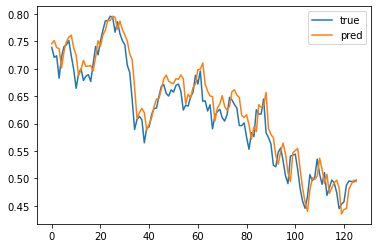

In [8]:
model.eval()
y_list = list()
y_hat_list = list()

for batch_x, batch_y in dataloader_test:
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    y_hat = model(batch_x)

    y_list += batch_y.flatten().tolist()
    y_hat_list += y_hat.flatten().tolist()

import matplotlib.pyplot as plt

plt.plot(y_list, label="true")
plt.plot(y_hat_list, label="pred")
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date'>

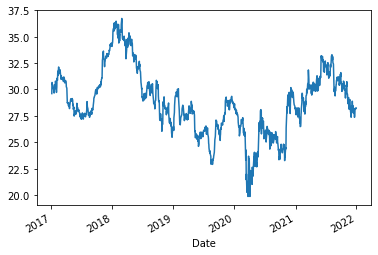

In [24]:
df['Close'].plot()

## これ以降をバッチ化していないコード → 遅い

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(4, 4)
        self.linear = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, (h, c) = self.lstm(x)
        #print("================")
        #print(out)
        out = self.linear(out[-1])
        y_hat = self.sigmoid(out)

        return y_hat

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

patience_step = 0
patience_loss = float('inf')

for epoch in range(10000):
    epoch_loss = 0
    for x, y in zip(train_x, train_y):
        x = torch.tensor(x, dtype=torch.float).to(device)
        y = torch.tensor([y], dtype=torch.float).to(device)

        y_hat = model(x)

        loss = criterion(y_hat, y)

        epoch_loss += loss # .item()

        loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss /= len(train_x)

    '''
    if patience_loss < epoch_loss:
        patience_step += 1
        if patience_step > 50: # 10 epoch 連続で loss が前回をうわ丸用ならば
            break # 学習の終了
    else:
        patience_step = 0
        patience_loss = epoch_loss
    '''

    if (epoch+1) % 100 == 0:
        print("epoch {}: {}".format(epoch+1, epoch_loss))
    

epoch 100: 0.0043321410194039345
epoch 200: 0.0006673765019513667
epoch 300: 0.00045317134936340153
epoch 400: 0.00037709754542447627
epoch 500: 0.0003122913185507059
epoch 600: 0.0002636206627357751
epoch 700: 0.000227602751692757
epoch 800: 0.00020131203928031027
epoch 900: 0.0001823762577259913
epoch 1000: 0.00016871395928319544
epoch 1100: 0.00015865577734075487
epoch 1200: 0.00015101391181815416
epoch 1300: 0.0001450020936317742
epoch 1400: 0.0001401211484335363
epoch 1500: 0.00013604492414742708
epoch 1600: 0.00013256991223897785
epoch 1700: 0.00012955906277056783
epoch 1800: 0.0001269197091460228
epoch 1900: 0.00012458744458854198
epoch 2000: 0.00012251257430762053
epoch 2100: 0.00012065772170899436
epoch 2200: 0.00011899122910108417
epoch 2300: 0.00011749087570933625
epoch 2400: 0.00011613935930654407
epoch 2500: 0.0001149222589447163
epoch 2600: 0.00011382951925043017
epoch 2700: 0.0001128522926592268
epoch 2800: 0.00011198299034731463
epoch 2900: 0.00011121454735985026
epoch 

KeyboardInterrupt: ignored

In [32]:
model.eval()
y_list = list()
y_hat_list = list()

for x, y in zip(test_x, test_y):
    x = torch.tensor(x, dtype=torch.float).to(device)
    # y = torch.tensor([y], dtype=torch.float).to(device)

    y_hat = model(x)

    y_list.append(y.item())
    y_hat_list.append(y_hat.item())

RuntimeError: ignored

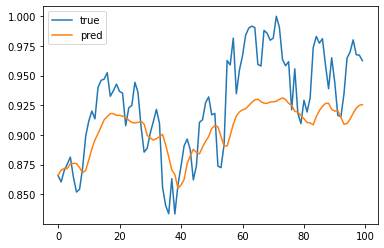

In [10]:
import matplotlib.pyplot as plt

plt.plot(y_list, label="true")
plt.plot(y_hat_list, label="pred")
plt.legend()
plt.show()